In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import group_glm as gm
from glm_utils import *
from scipy.stats import linregress
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [2]:
import pandas as pd

# Download experiment containers for VISp experiments, with imaging depth 350 
ecs = boc.get_experiment_containers()
ids = [ ec['id'] for ec in ecs ]

#just look at cells from the first experiment container
exp = boc.get_ophys_experiments(experiment_container_ids=ids)
ids = [ ec['id'] for ec in exp ]
data_set = boc.get_ophys_experiment_data(502066273)

In [3]:
from allensdk.brain_observatory.dff import compute_dff


time, dff_traces = data_set.get_dff_traces()

scenes = data_set.get_stimulus_template('natural_movie_one')
stim_table = data_set.get_stimulus_table(stim_info.NATURAL_MOVIE_ONE)

In [4]:
from sklearn.decomposition import PCA

model = PCA()
scenes_r = model.fit_transform(scenes.reshape([len(scenes), -1]))

In [14]:
dff_traces.shape

(81, 105738)

In [19]:
#declare a dictionary of empty lists for each cell trace, 
#and a list for the stimulus
data = None
stim_array = []
im_array = [] #keep track of which image index each stimulus is, so we can check 'explainable variance'

#average each trace over the presentation of each stimulus, and add
#to dictionary with cell id as keys

for index, row in stim_table.iterrows():
    stim_array.append(scenes_r[row.frame, 0:50])
    
    if data == None:
        data = dff_traces[:, row['start']:row['end']]
    else:
        data = np.concatenate((data, dff_traces[:, row['start']:row['start'] + 1]), axis = 1)
    
stim_array = np.array(stim_array)
data = np.array(data).T

/home/amy/.local/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [20]:
design = np.zeros([9000, 81, 50])

for i in range(81):
    design[:, i, :] = stim_array

In [34]:
weight = np.linalg.pinv(stim_array).dot(data)

model = gm.exponential_GLM(weight_init = weight.T, lr = 0.001, alpha = 0, non_lin = tf.nn.sigmoid)

In [35]:
l, _ =model.fit(design.reshape(-1, 81*50), data, design.reshape(-1, 81*50), data, max_iters= 500)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:17


In [30]:
w, s, o = model.get

AttributeError: exponential_GLM instance has no attribute 'get'

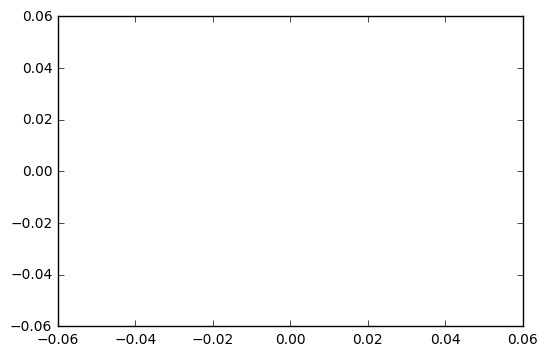

In [33]:
plt.plot(l)